In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import random
import numpy as np

from sklearn import linear_model, cross_validation, metrics, svm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pydoop.hdfs as hdfs
def read_csv_from_hdfs(path, cols, col_types=None):
  files = hdfs.ls(path);
  pieces = []
  for f in files:
    fhandle = hdfs.open(f)
    pieces.append(pd.read_csv(fhandle, names=cols, dtype=col_types))
    fhandle.close()
  return pd.concat(pieces, ignore_index=True)

In [3]:
cols = ['year', 'month', 'day', 'dow', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'Carrier', 'FlightNum', 
        'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest', 
        'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay', 
        'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'];
flt_2007 = read_csv_from_hdfs('/airline/delay/2007.csv', cols)
flt_2007.shape

(7453216, 29)

In [4]:
df = flt_2007[flt_2007['Origin']=='ORD'].dropna(subset=['DepDelay'])
df['DepDelayed'] = df['DepDelay'].apply(lambda x: x>=15)
print "total flights: " + str(df.shape[0])
print "total delays: " + str(df['DepDelayed'].sum())

total flights: 359169
total delays: 109346


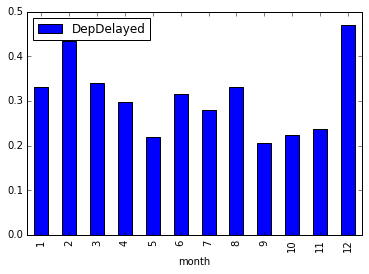

In [5]:
# Select a Pandas dataframe with flight originating from ORD

# Compute average number of delayed flights per month
grouped = df[['DepDelayed', 'month']].groupby('month').mean()

# plot average delays by month
grouped.plot(kind='bar')

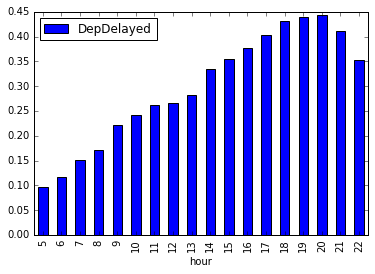

In [6]:
df['hour'] = df['CRSDepTime'].map(lambda x: int(str(int(x)).zfill(4)[:2]))
grouped = df[['DepDelayed', 'hour']].groupby('hour').mean()

# plot average delays by hour of day
grouped.plot(kind='bar')

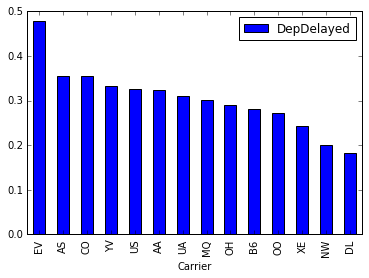

In [7]:
# Compute average number of delayed flights per carrier
grouped1 = df[['DepDelayed', 'Carrier']].groupby('Carrier').filter(lambda x: len(x)>10)
grouped2 = grouped1.groupby('Carrier').mean()
carrier = grouped2.sort(['DepDelayed'], ascending=False)

# display top 15 destination carriers by delay (from ORD)
carrier[:15].plot(kind='bar')

In [8]:
%%writefile preprocess1.pig

Register 'util.py' USING jython as util;
DEFINE preprocess(year_str, airport_code) returns data
{
        -- load airline data from specified year (need to specify fields since it's not in HCat)
        airline = load '/airline/delay/$year_str.csv' using PigStorage(',') 
            as (Year: int, Month: int, DayOfMonth: int, DayOfWeek: int, DepTime: chararray, 
                CRSDepTime: chararray, ArrTime, CRSArrTime, Carrier: chararray, FlightNum, TailNum, ActualElapsedTime, 
                CRSElapsedTime, AirTime, ArrDelay, DepDelay: int, Origin: chararray, Dest: chararray, Distance: int, 
                TaxiIn, TaxiOut, Cancelled: int, CancellationCode, Diverted, CarrierDelay, WeatherDelay, 
                NASDelay, SecurityDelay, LateAircraftDelay);

    -- keep only instances where flight was not cancelled and originate at ORD
        airline_flt = filter airline by Cancelled == 0 and Origin == '$airport_code';

    -- Keep only fields I need
        $data = foreach airline_flt generate DepDelay as delay, Month, DayOfMonth, DayOfWeek, 
                                             util.get_hour(CRSDepTime) as hour, Distance, Carrier, Dest,
                                             util.days_from_nearest_holiday(Year, Month, DayOfMonth) as hdays;
};
ORD_2007 = preprocess('2007', 'ORD');
store ORD_2007 into '/airline/delay/ord_2007_1' using PigStorage(',');
ORD_2008 = preprocess('2008', 'ORD');
store ORD_2008 into '/airline/delay/ord_2008_1' using PigStorage(',');

Overwriting preprocess1.pig


In [9]:
%%bash --err pig_out --bg 
pig -f preprocess1.pig

Starting job # 0 in a separate thread.


In [10]:
while True:
    line = pig_out.readline()
    if not line: 
        break
    sys.stdout.write("%s" % line)
    sys.stdout.flush()

16/04/15 18:24:10 INFO pig.ExecTypeProvider: Trying ExecType : LOCAL
16/04/15 18:24:10 INFO pig.ExecTypeProvider: Trying ExecType : MAPREDUCE
16/04/15 18:24:10 INFO pig.ExecTypeProvider: Picked MAPREDUCE as the ExecType
2016-04-15 18:24:10,755 [main] INFO  org.apache.pig.Main - Apache Pig version 0.15.0 (r1682971) compiled Jun 01 2015, 11:44:35
2016-04-15 18:24:10,755 [main] INFO  org.apache.pig.Main - Logging error messages to: /Users/abhishekashwathnarayanvenkat/pig_1460759050753.log
2016-04-15 18:24:11,147 [main] WARN  org.apache.hadoop.util.NativeCodeLoader - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2016-04-15 18:24:11,359 [main] INFO  org.apache.pig.impl.util.Utils - Default bootup file /Users/abhishekashwathnarayanvenkat/.pigbootup not found
2016-04-15 18:24:11,580 [main] INFO  org.apache.hadoop.conf.Configuration.deprecation - mapred.job.tracker is deprecated. Instead, use mapreduce.jobtracker.address
2016-04-15 18:24:

In [11]:
cols = ['delay', 'month', 'day', 'dow', 'hour', 'distance', 'carrier', 'dest', 'days_from_holiday']
col_types = {'delay': int, 'month': int, 'day': int, 'dow': int, 'hour': int, 'distance': int, 
             'carrier': str, 'dest': str, 'days_from_holiday': int}
data_2007 = read_csv_from_hdfs('/airline/delay/ord_2007_1', cols, col_types)
data_2008 = read_csv_from_hdfs('/airline/delay/ord_2008_1', cols, col_types)

# Create training set and test set
cols = ['month', 'day', 'dow', 'hour', 'distance', 'days_from_holiday']
train_y = data_2007['delay'] >= 15
train_x = data_2007[cols]

test_y = data_2008['delay'] >= 15
test_x = data_2008[cols]

print train_x.shape

(359169, 6)


In [12]:
# Create logistic regression model with L2 regularization
clf_lr = linear_model.LogisticRegression(penalty='l2', class_weight='auto')
clf_lr.fit(train_x, train_y)

# Predict output labels on test set
pr = clf_lr.predict(test_x)

# display evaluation metrics
cm = confusion_matrix(test_y, pr)
print("Confusion matrix")
print(pd.DataFrame(cm))
report_lr = precision_recall_fscore_support(list(test_y), list(pr), average='micro')
print "\nprecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % \
        (report_lr[0], report_lr[1], report_lr[2], accuracy_score(list(test_y), list(pr)))

/Users/abhishekashwathnarayanvenkat/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Confusion matrix
        0      1
0  143805  96089
1   36958  58478

precision = 0.38, recall = 0.61, F1 = 0.47, accuracy = 0.60



/Users/abhishekashwathnarayanvenkat/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


In [13]:
# Create Random Forest classifier with 50 trees
clf_rf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
clf_rf.fit(train_x, train_y)

# Evaluate on test set
pr = clf_rf.predict(test_x)

# print results
cm = confusion_matrix(test_y, pr)
print("Confusion matrix")
print(pd.DataFrame(cm))
report_svm = precision_recall_fscore_support(list(test_y), list(pr), average='micro')
print "\nprecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % \
        (report_svm[0], report_svm[1], report_svm[2], accuracy_score(list(test_y), list(pr)))

Confusion matrix
        0      1
0  197182  42712
1   65807  29629


/Users/abhishekashwathnarayanvenkat/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)



precision = 0.41, recall = 0.31, F1 = 0.35, accuracy = 0.68



In [19]:
from sklearn.preprocessing import OneHotEncoder

# read files
cols = ['delay', 'month', 'day', 'dow', 'hour', 'distance', 'carrier', 'dest', 'days_from_holiday']
col_types = {'delay': int, 'month': int, 'day': int, 'dow': int, 'hour': int, 'distance': int, 
             'carrier': str, 'dest': str, 'days_from_holiday': int}
data_2007 = read_csv_from_hdfs('/airline/delay/ord_2007_1', cols, col_types)
data_2008 = read_csv_from_hdfs('/airline/delay/ord_2008_1', cols, col_types)

# Create training set and test set
train_y = data_2007['delay'] >= 15
categ = [cols.index(x) for x in 'hour', 'month', 'day', 'dow', 'carrier', 'dest']
enc = OneHotEncoder(categorical_features = categ)
df = data_2007.drop('delay', axis=1)
df['carrier'] = pd.factorize(df['carrier'])[0]
df['dest'] = pd.factorize(df['dest'])[0]
train_x = enc.fit_transform(df)

test_y = data_2008['delay'] >= 15
df = data_2008.drop('delay', axis=1)
df['carrier'] = pd.factorize(df['carrier'])[0]
df['dest'] = pd.factorize(df['dest'])[0]
test_x = enc.transform(df)

print train_x.shape

(359169, 409)


In [20]:
# Create Random Forest classifier with 50 trees
clf_rf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
clf_rf.fit(train_x.toarray(), train_y)

# Evaluate on test set
pr = clf_rf.predict(test_x.toarray())

# print results
cm = confusion_matrix(test_y, pr)
print("Confusion matrix")
print(pd.DataFrame(cm))
report_svm = precision_recall_fscore_support(list(test_y), list(pr), average='micro')
print "\nprecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % \
        (report_svm[0], report_svm[1], report_svm[2], accuracy_score(list(test_y), list(pr)))

Confusion matrix
        0      1
0  216488  23406
1   75193  20243


/Users/abhishekashwathnarayanvenkat/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)



precision = 0.46, recall = 0.21, F1 = 0.29, accuracy = 0.71



In [59]:
%%writefile preprocess2.pig

register 'util.py' USING jython as util;

-- Helper macro to load data and join into a feature vector per instance
DEFINE preprocess(year_str, airport_code) returns data
{
    -- load airline data from specified year (need to specify fields since it's not in HCat)
    airline = load '/airline/delay/$year_str.csv' using PigStorage(',') 
                    as (Year: int, Month: int, DayOfMonth: int, DayOfWeek: int, DepTime: chararray, CRSDepTime:chararray, 
                        ArrTime, CRSArrTime, Carrier: chararray, FlightNum, TailNum, ActualElapsedTime, CRSElapsedTime, AirTime, 
                        ArrDelay, DepDelay: int, Origin: chararray, Dest: chararray, Distance: int, TaxiIn, TaxiOut, 
                        Cancelled: int, CancellationCode, Diverted, CarrierDelay, WeatherDelay, NASDelay, 
                        SecurityDelay, LateAircraftDelay);

    -- keep only instances where flight was not cancelled and originate at ORD
    airline_flt = filter airline by Cancelled == 0 and Origin == '$airport_code';

    -- Keep only fields I need
    airline2 = foreach airline_flt generate Year as year, Month as month, DayOfMonth as day, DayOfWeek as dow,
                        Carrier as carrier, Origin as origin, Dest as dest, Distance as distance,
                        CRSDepTime as time, DepDelay as delay, util.to_date(Year, Month, DayOfMonth) as date;

    -- load weather data
    weather = load '/airline/weather/$year_str.csv' using PigStorage(',') 
                    as (STATION: chararray, date: chararray, PRCP:float, SNOW:float, TMAX:int, TMIN:int, AWND:float);

    -- keep only TMIN and TMAX weather observations from ORD
    --weather_tmin = filter weather by station == 'USW00094846' and metric == 'TMIN';
    --weather_tmax = filter weather by station == 'USW00094846' and metric == 'TMAX';
    --weather_prcp = filter weather by station == 'USW00094846' and metric == 'PRCP';
    --weather_snow = filter weather by station == 'USW00094846' and metric == 'SNOW';
    --weather_awnd = filter weather by station == 'USW00094846' and metric == 'AWND';

    joined = join airline2 by date, weather by date;
    $data = foreach joined generate delay, month, day, dow, util.get_hour(airline2::time) as tod, distance, carrier, dest,
                                    util.days_from_nearest_holiday(year, month, day) as hdays,
                                    weather::TMIN as temp_min, weather::TMAX as temp_max,
                                    weather::PRCP as prcp, weather::SNOW as snow, weather::AWND as wind;
};

ORD_2007 = preprocess('2007', 'ORD');
--rmf airline/delay/ord_2007_2;
store ORD_2007 into '/airline/delay/ord_2007_2' using PigStorage(',');

ORD_2008 = preprocess('2008', 'ORD');
--rmf airline/fm/ord_2008_2;
store ORD_2008 into '/airline/delay/ord_2008_2' using PigStorage(',');

Overwriting preprocess2.pig


In [60]:
%%bash --bg --err pig_out2 
pig -f preprocess2.pig

Starting job # 14 in a separate thread.


In [61]:
while True:
    line = pig_out2.readline()
    if not line:
        break
    sys.stdout.write("%s" % line)
    sys.stdout.flush()

16/04/15 22:36:59 INFO pig.ExecTypeProvider: Trying ExecType : LOCAL
16/04/15 22:36:59 INFO pig.ExecTypeProvider: Trying ExecType : MAPREDUCE
16/04/15 22:36:59 INFO pig.ExecTypeProvider: Picked MAPREDUCE as the ExecType
2016-04-15 22:36:59,303 [main] INFO  org.apache.pig.Main - Apache Pig version 0.15.0 (r1682971) compiled Jun 01 2015, 11:44:35
2016-04-15 22:36:59,303 [main] INFO  org.apache.pig.Main - Logging error messages to: /Users/abhishekashwathnarayanvenkat/pig_1460774219301.log
2016-04-15 22:36:59,733 [main] WARN  org.apache.hadoop.util.NativeCodeLoader - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2016-04-15 22:37:00,003 [main] INFO  org.apache.pig.impl.util.Utils - Default bootup file /Users/abhishekashwathnarayanvenkat/.pigbootup not found
2016-04-15 22:37:00,216 [main] INFO  org.apache.hadoop.conf.Configuration.deprecation - mapred.job.tracker is deprecated. Instead, use mapreduce.jobtracker.address
2016-04-15 22:37:

In [62]:
from sklearn.preprocessing import OneHotEncoder

# Convert Celsius to Fahrenheit
def fahrenheit(x): return(x*1.8 + 32.0)

# read files
cols = ['delay', 'month', 'day', 'dow', 'hour', 'distance', 'carrier', 'dest', 'days_from_holiday',
        'origin_tmin', 'origin_tmax', 'origin_prcp', 'origin_snow', 'origin_wind']
col_types = {'delay': int, 'month': int, 'day': int, 'dow': int, 'hour': int, 'distance': int, 
             'carrier': str, 'dest': str, 'days_from_holiday': int,
             'origin_tmin': float, 'origin_tmax': float, 'origin_prcp': float, 'origin_snow': float, 'origin_wind': float}

data_2007 = read_csv_from_hdfs('/airline/delay/ord_2007_2', cols, col_types)
data_2008 = read_csv_from_hdfs('/airline/delay/ord_2008_2', cols, col_types)

In [63]:
data_2007['origin_tmin'] = data_2007['origin_tmin'].apply(lambda x: fahrenheit(x/10.0))
data_2007['origin_tmax'] = data_2007['origin_tmax'].apply(lambda x: fahrenheit(x/10.0))
data_2008['origin_tmin'] = data_2008['origin_tmin'].apply(lambda x: fahrenheit(x/10.0))
data_2008['origin_tmax'] = data_2008['origin_tmax'].apply(lambda x: fahrenheit(x/10.0))

# Create training set and test set
train_y = data_2007['delay'] >= 15
categ = [cols.index(x) for x in 'hour', 'month', 'day', 'dow', 'carrier', 'dest']
enc = OneHotEncoder(categorical_features = categ)
df = data_2007.drop('delay', axis=1)
df['carrier'] = pd.factorize(df['carrier'])[0]
df['dest'] = pd.factorize(df['dest'])[0]
train_x = enc.fit_transform(df)

test_y = data_2008['delay'] >= 15
df = data_2008.drop('delay', axis=1)
df['carrier'] = pd.factorize(df['carrier'])[0]
df['dest'] = pd.factorize(df['dest'])[0]
test_x = enc.transform(df)

print train_x.shape

(62167, 355)


In [64]:
# Create Random Forest classifier with 100 trees
clf_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
clf_rf.fit(train_x.toarray(), train_y)

# Evaluate on test set
pr = clf_rf.predict(test_x.toarray())

# print results
cm = confusion_matrix(test_y, pr)
print("Confusion matrix")
print(pd.DataFrame(cm))
report_rf = precision_recall_fscore_support(list(test_y), list(pr), average='micro')
print "precision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % \
        (report_rf[0], report_rf[1], report_rf[2], accuracy_score(list(test_y), list(pr)))

Confusion matrix
       0     1
0  36755  4527
1   8276  5197
precision = 0.53, recall = 0.39, F1 = 0.45, accuracy = 0.77



/Users/abhishekashwathnarayanvenkat/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
